In [1]:
# DATASET LINK.. https://nihcc.app.box.com/v/ChestXray-NIHCC/folder/36938765345
# It has all the informations within it....


import pandas as pd
import numpy as np
import os, shutil
from sklearn.model_selection import GroupKFold, KFold
from glob import glob
from tqdm.notebook import tqdm
import cv2

import seaborn as sns
import matplotlib.pyplot as plt




import warnings
warnings.filterwarnings("ignore")

In [2]:
# Fourteen common thoracic pathologies include Atelectasis, Consolidation, Infiltration,
# Pneumothorax, Edema, Emphysema, Fibrosis, Effusion, Pneumonia, Pleural_thickening,
# Cardiomegaly, Nodule, Mass and Hernia

In [3]:
data =pd.read_csv ("/kaggle/input/data/BBox_List_2017.csv")

In [4]:
data.head()

,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,NaN,NaN,NaN
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,NaN,NaN,NaN
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,NaN,NaN,NaN
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,NaN,NaN,NaN


In [5]:
data = data.drop (data.iloc [:, 6:9], axis = 1)
data.head ()

,Image Index,Finding Label,Bbox [x,y,w,h]
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695


In [6]:
print ('Number of all boxes:', (data.shape[0]))
print ('Number of unique patients:',len (data['Image Index'].unique ()))

Number of all boxes: 984
Number of unique patients: 880


In [7]:

list(data['Finding Label'].unique())

['Atelectasis',
 'Cardiomegaly',
 'Effusion',
 'Infiltrate',
 'Mass',
 'Nodule',
 'Pneumonia',
 'Pneumothorax']

In [8]:
len(list(data['Finding Label'].unique()))

8

In [9]:
nhif_list  = list(data['Finding Label'].unique())
nhif_list

['Atelectasis',
 'Cardiomegaly',
 'Effusion',
 'Infiltrate',
 'Mass',
 'Nodule',
 'Pneumonia',
 'Pneumothorax']

In [10]:
data ['class_id'] = data ['Finding Label'].apply (lambda x: nhif_list.index (x))
data.head ()

,Image Index,Finding Label,Bbox [x,y,w,h],class_id
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,0
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,0
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,0
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,0
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,0


In [11]:
dim_data = pd.read_csv("../input/data/Data_Entry_2017.csv")

In [12]:
dim_data.shape

(112120, 12)

In [13]:
dim_data.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [14]:
dim_data.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'],
      dtype='object')

In [15]:
dimensions = dim_data[['Image Index','OriginalImage[Width', 'Height]']]
dimensions.head()

,Image Index,OriginalImage[Width,Height]
0,00000001_000.png,2682,2749
1,00000001_001.png,2894,2729
2,00000001_002.png,2500,2048
3,00000002_000.png,2500,2048
4,00000003_000.png,2582,2991


In [16]:
dimensions = dimensions.rename({'Height]':'height','Image Index':'file_names','OriginalImage[Width':"width"},axis=1)

In [17]:
df = data.sample(frac=1)

In [18]:
df.shape

(984, 7)

In [19]:
df.head()

,Image Index,Finding Label,Bbox [x,y,w,h],class_id
396,00022572_005.png,Effusion,144.118519,189.629630,230.806349,478.950265,2
537,00017981_014.png,Infiltrate,254.645503,312.076190,195.047619,139.784127,3
376,00021967_000.png,Effusion,182.044444,92.105820,365.172487,586.226455,2
216,00028873_009.png,Cardiomegaly,333.559322,281.762712,394.847458,356.881356,1
809,00007629_001.png,Pneumonia,631.737566,465.947090,174.459259,178.793651,6


In [20]:
df['Finding Label'].value_counts(normalize=True)

Atelectasis     0.182927
Effusion        0.155488
Cardiomegaly    0.148374
Infiltrate      0.125000
Pneumonia       0.121951
Pneumothorax    0.099593
Mass            0.086382
Nodule          0.080285
Name: Finding Label, dtype: float64

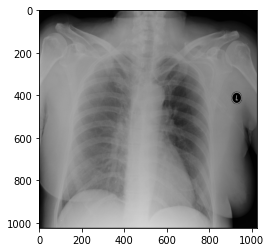

In [21]:
img = cv2.imread("../input/data/images_001/images/00000005_002.png")
plt.imshow(img)

In [22]:
img.shape

(1024, 1024, 3)

In [23]:
# get the boounding boxes upper and lower locations in order to draw the boxes

In [24]:
df = df.rename (columns = {'Bbox [x': 'x', 'h]': 'h'})

In [25]:
df = df.rename({"Image Index":"file_names"}, axis=1)
df = df.rename({"Finding Label":"class_names"}, axis=1)

In [26]:
df.head()

,file_names,class_names,x,y,w,h,class_id
396,00022572_005.png,Effusion,144.118519,189.629630,230.806349,478.950265,2
537,00017981_014.png,Infiltrate,254.645503,312.076190,195.047619,139.784127,3
376,00021967_000.png,Effusion,182.044444,92.105820,365.172487,586.226455,2
216,00028873_009.png,Cardiomegaly,333.559322,281.762712,394.847458,356.881356,1
809,00007629_001.png,Pneumonia,631.737566,465.947090,174.459259,178.793651,6


In [27]:
dimensions.index = dimensions['file_names']

In [28]:
dimensions.loc['00017214_015.png']

file_names    00017214_015.png
width                     2748
height                    2544
Name: 00017214_015.png, dtype: object

In [29]:
Extract_Dimensions = lambda x: dimensions.loc[x][['height', 'width']]

In [30]:
df[['height', "width"]] = df['file_names'].apply(Extract_Dimensions).reset_index(drop=True)

In [31]:
df.head()

,file_names,class_names,x,y,w,h,class_id,height,width
396,00022572_005.png,Effusion,144.118519,189.629630,230.806349,478.950265,2,2048,2500
537,00017981_014.png,Infiltrate,254.645503,312.076190,195.047619,139.784127,3,2544,3056
376,00021967_000.png,Effusion,182.044444,92.105820,365.172487,586.226455,2,2021,2021
216,00028873_009.png,Cardiomegaly,333.559322,281.762712,394.847458,356.881356,1,2048,2500
809,00007629_001.png,Pneumonia,631.737566,465.947090,174.459259,178.793651,6,2508,3056


In [32]:
# xmax = x+add_suffixw
# xmin = x-w
# ymax = y+h
# ymin = y-h



In [37]:
df['xmax'] = df['x'] + df['w']#/2
df['ymax'] = df['y'] + df['h']#/2
df['xmin'] = df['x'] #- df['w']/2
df['ymin'] = df['y'] #- df['h']/2

# df['xmax'] = df['w'] #+ df['w']/2
# df['ymax'] = df['h'] #+ df['h']/2
# df['xmin'] = df['x'] #- df['w']/2
# df['ymin'] = df['y'] #- df['h']/2

In [38]:
df.head()

,file_names,class_names,x,y,w,h,class_id,height,width,xmax,ymax,xmin,ymin
396,00022572_005.png,Effusion,144.118519,189.629630,230.806349,478.950265,2,2048,2500,374.924868,668.579894,144.118519,189.629630
537,00017981_014.png,Infiltrate,254.645503,312.076190,195.047619,139.784127,3,2544,3056,449.693122,451.860317,254.645503,312.076190
376,00021967_000.png,Effusion,182.044444,92.105820,365.172487,586.226455,2,2021,2021,547.216931,678.332275,182.044444,92.105820
216,00028873_009.png,Cardiomegaly,333.559322,281.762712,394.847458,356.881356,1,2048,2500,728.406780,638.644068,333.559322,281.762712
809,00007629_001.png,Pneumonia,631.737566,465.947090,174.459259,178.793651,6,2508,3056,806.196825,644.740741,631.737566,465.947090


In [39]:
# get the image path
# adding path to dataframe
all_image_paths = {os.path.basename(x): x for x in glob ('../input/data/images_*/images/*.png')}
df ['path'] = df ['file_names'].map(all_image_paths.get)
df.head ()

,file_names,class_names,x,y,w,h,class_id,height,width,xmax,ymax,xmin,ymin,path
396,00022572_005.png,Effusion,144.118519,189.629630,230.806349,478.950265,2,2048,2500,374.924868,668.579894,144.118519,189.629630,../input/data/images_010/images/00022572_005.png
537,00017981_014.png,Infiltrate,254.645503,312.076190,195.047619,139.784127,3,2544,3056,449.693122,451.860317,254.645503,312.076190,../input/data/images_008/images/00017981_014.png
376,00021967_000.png,Effusion,182.044444,92.105820,365.172487,586.226455,2,2021,2021,547.216931,678.332275,182.044444,92.105820,../input/data/images_010/images/00021967_000.png
216,00028873_009.png,Cardiomegaly,333.559322,281.762712,394.847458,356.881356,1,2048,2500,728.406780,638.644068,333.559322,281.762712,../input/data/images_012/images/00028873_009.png
809,00007629_001.png,Pneumonia,631.737566,465.947090,174.459259,178.793651,6,2508,3056,806.196825,644.740741,631.737566,465.947090,../input/data/images_004/images/00007629_001.png


In [40]:

for idx in range(df.reset_index(drop=True).shape[0]):
    im = cv2.imread(df.iloc[idx]['path'])
    if im.shape != (1024, 1024, 3):
        print("Incorect.....", im.shape)

In [41]:
# normalize the center and widht/height dimensions
df ['x'] =  df ['x'].apply (lambda r: r / 1024)#df['x']/df['width']
df ['y'] = df ['y'].apply (lambda r: r / 1024) #df['y']/df['height']
df ['w'] = df ['w'].apply (lambda r: r / 1024) #df['w']/df['width']
df ['h'] = df ['h'].apply (lambda r: r / 1024) #df['h']/df['height']
df.head ()

,file_names,class_names,x,y,w,h,class_id,height,width,xmax,ymax,xmin,ymin,path
396,00022572_005.png,Effusion,0.140741,0.185185,0.225397,0.467725,2,2048,2500,374.924868,668.579894,144.118519,189.629630,../input/data/images_010/images/00022572_005.png
537,00017981_014.png,Infiltrate,0.248677,0.304762,0.190476,0.136508,3,2544,3056,449.693122,451.860317,254.645503,312.076190,../input/data/images_008/images/00017981_014.png
376,00021967_000.png,Effusion,0.177778,0.089947,0.356614,0.572487,2,2021,2021,547.216931,678.332275,182.044444,92.105820,../input/data/images_010/images/00021967_000.png
216,00028873_009.png,Cardiomegaly,0.325742,0.275159,0.385593,0.348517,1,2048,2500,728.406780,638.644068,333.559322,281.762712,../input/data/images_012/images/00028873_009.png
809,00007629_001.png,Pneumonia,0.616931,0.455026,0.170370,0.174603,6,2508,3056,806.196825,644.740741,631.737566,465.947090,../input/data/images_004/images/00007629_001.png


In [42]:
df.head(2)

,file_names,class_names,x,y,w,h,class_id,height,width,xmax,ymax,xmin,ymin,path
396,00022572_005.png,Effusion,0.140741,0.185185,0.225397,0.467725,2,2048,2500,374.924868,668.579894,144.118519,189.62963,../input/data/images_010/images/00022572_005.png
537,00017981_014.png,Infiltrate,0.248677,0.304762,0.190476,0.136508,3,2544,3056,449.693122,451.860317,254.645503,312.07619,../input/data/images_008/images/00017981_014.png


In [43]:
df.reset_index(drop=True, inplace=True)

In [44]:
(72.19+67.19+69.38+((68+74)/2))/4

69.94

In [45]:
((75*4)+(65*2)+(55*2))/8

67.5

In [46]:
# draw sample images

def draw_single_img(img_id):
    
    bb_df = df[df.file_names == img_id].reset_index(drop =True)
    file_path = bb_df.iloc[0]['path']
    BB_IMG = cv2.imread(f"{file_path}")
    new_bb_img = BB_IMG.copy()#cv2.resize(BB_IMG, (bb_df.iloc[0]['width'],bb_df.iloc[0]['height']))

    color = (255,0,0)
    for i in range(bb_df.shape[0]):
        row = bb_df.iloc[i]
        pt1 = int(row["xmin"]), int(row["ymin"])
        pt2 = int(row["xmax"]), int(row["ymax"])
        #height, width = row['height'], row['width']
        label = row["class_names"]
        ((text_width, text_height), _) = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1) 
        new_bb_img = cv2.rectangle(new_bb_img.copy(), pt1, pt2, color, int(max(new_bb_img.shape[:2]) / 500))
        #print(class_name)
        new_bb_img = cv2.putText(new_bb_img.copy(), label, (int(row["xmin"]), int(row["ymin"]) - int(0.1 * text_height)), cv2.FONT_HERSHEY_SIMPLEX,fontScale=1,color = (255,0,2), lineType=cv2.LINE_AA)

    plt.figure(figsize=(13,13))
    plt.imshow(new_bb_img)


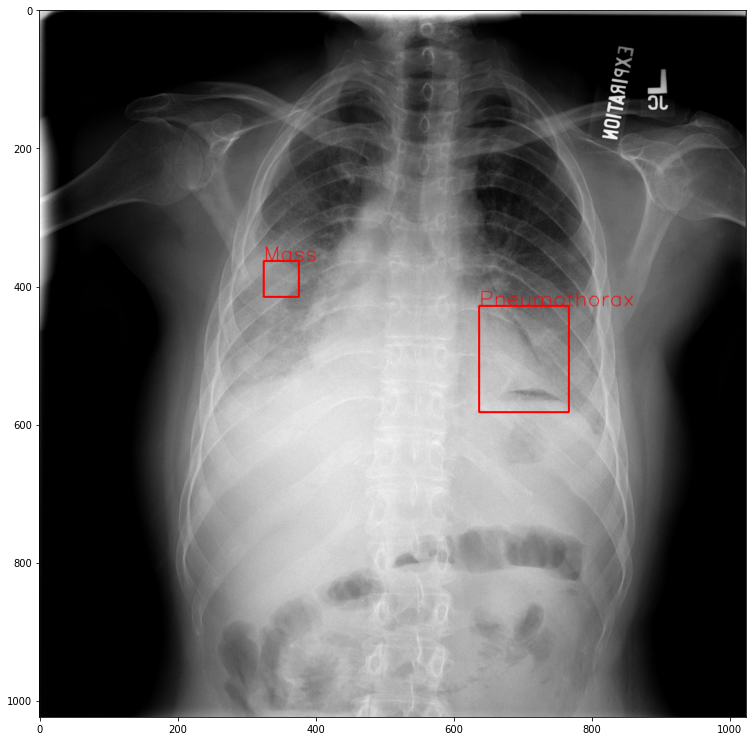

In [47]:
draw_single_img("00002106_000.png")

In [48]:
# lets plot multiple
def plot_multiple_img(img_matrix_list, title_list, ncols, main_title=""):
    fig, myaxes = plt.subplots(figsize=(25, 20), nrows=3, ncols=ncols, squeeze=False)
    fig.suptitle(main_title, fontsize = 30)
    fig.subplots_adjust(wspace=0.3)
    fig.subplots_adjust(hspace=0.3)
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize=9)
    plt.show()

In [52]:
def draw_rect_with_labels(img, bboxes,class_id, class_dict, color=None):
    img = img.copy()
    bboxes = bboxes[:, :5]
    bboxes = bboxes.reshape(-1, 5)
    for bbox in bboxes:
        pt1, pt2 = (bbox[0], bbox[1]), (bbox[2], bbox[3])
        pt1 = int(pt1[0]), int(pt1[1])
        pt2 = int(pt2[0]), int(pt2[1])
        label = int(bbox[4])
        class_name = class_dict[label]
        ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.15, 1) 
        img = cv2.rectangle(img.copy(), pt1, pt2, color, int(max(img.shape[:2]) / 200))
        #print(class_name)
        img = cv2.putText(img.copy(), class_name, (int(bbox[0]), int(bbox[1]) - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX,fontScale=1,color = (255,255,255), lineType=cv2.LINE_AA)

    return img

In [53]:
class_dict = {v:k for k,v in dict(df[['class_names', "class_id"]].values).items()}

class_dict

{2: 'Effusion',
 3: 'Infiltrate',
 1: 'Cardiomegaly',
 6: 'Pneumonia',
 4: 'Mass',
 0: 'Atelectasis',
 7: 'Pneumothorax',
 5: 'Nodule'}

In [54]:
def random_bbox_check(data, num = 12):
    img_dict = {}
    
    #skip_csv_header(file)
    counter =0
    for idx in range(data.shape[0]):
        row = data.iloc[idx]
        try:
            image_name, x_min, y_min, x_max, y_max, class_idx, h,w = (
                row['path'], 
                row['xmin'], row['ymin'],
                row['xmax'],row['ymax'], 
                row['class_id'],
                row['height'], row['width']
            )
            if image_name not in img_dict:
                img_dict[image_name] = list()
            img_dict[image_name].append(
                [float(x_min), float(y_min), float(x_max), float(y_max), int(class_idx), int(h), int(w)]
            )

        except ValueError:
            print("Could not convert float to string, likely that your data has empty values.")

    # randomly choose 12 image.
    img_files_list = np.random.choice(list(img_dict.keys()), num)
    print("The images' names are {}".format(img_files_list))
    image_file_path_list = []

    bbox_list = []
    img_matrix_list = []
    random_image_matrix_list = []
    class_ids =[]
    
    for img_file in img_files_list:
        image_file_path = os.path.join(img_file)
        img = cv2.imread(image_file_path)[:,:,::-1]
        #print(img.shape)
        #img = cv2.resize(img, (img_dict[img_file][0][-2], img_dict[img_file][0][-1]))
        height, width, channels = img.shape
        bbox_list.append(img_dict[img_file])
        #print(img_dict[img_file])
        img_matrix_list.append(img)

    
    final_bbox_list = []
    for bboxes, img in zip(bbox_list, img_matrix_list):
        final_bbox_array = np.array([])
        #print(bboxes)
        #bboxes is a 2d array [[...], [...]]
        for bbox in bboxes:
            bbox = np.array(bbox).reshape(1,7)
            final_bbox_array = np.append(final_bbox_array, bbox)
        final_bbox_array = final_bbox_array.reshape(-1,7)
        random_image = draw_rect_with_labels(img.copy(), final_bbox_array.copy(),1,class_dict,  color = (255,0,0))
        random_image_matrix_list.append(random_image)
    plot_multiple_img(random_image_matrix_list, title_list = img_files_list, ncols = 4, main_title="Bounding Box Pathologies Images")    

The images' names are ['../input/data/images_005/images/00010092_018.png'
 '../input/data/images_003/images/00004381_021.png'
 '../input/data/images_010/images/00021377_016.png'
 '../input/data/images_011/images/00025662_006.png'
 '../input/data/images_009/images/00018427_011.png'
 '../input/data/images_009/images/00020564_000.png'
 '../input/data/images_007/images/00015770_010.png'
 '../input/data/images_011/images/00027652_003.png'
 '../input/data/images_012/images/00030634_000.png'
 '../input/data/images_005/images/00009256_005.png'
 '../input/data/images_008/images/00018101_012.png'
 '../input/data/images_002/images/00001787_008.png']


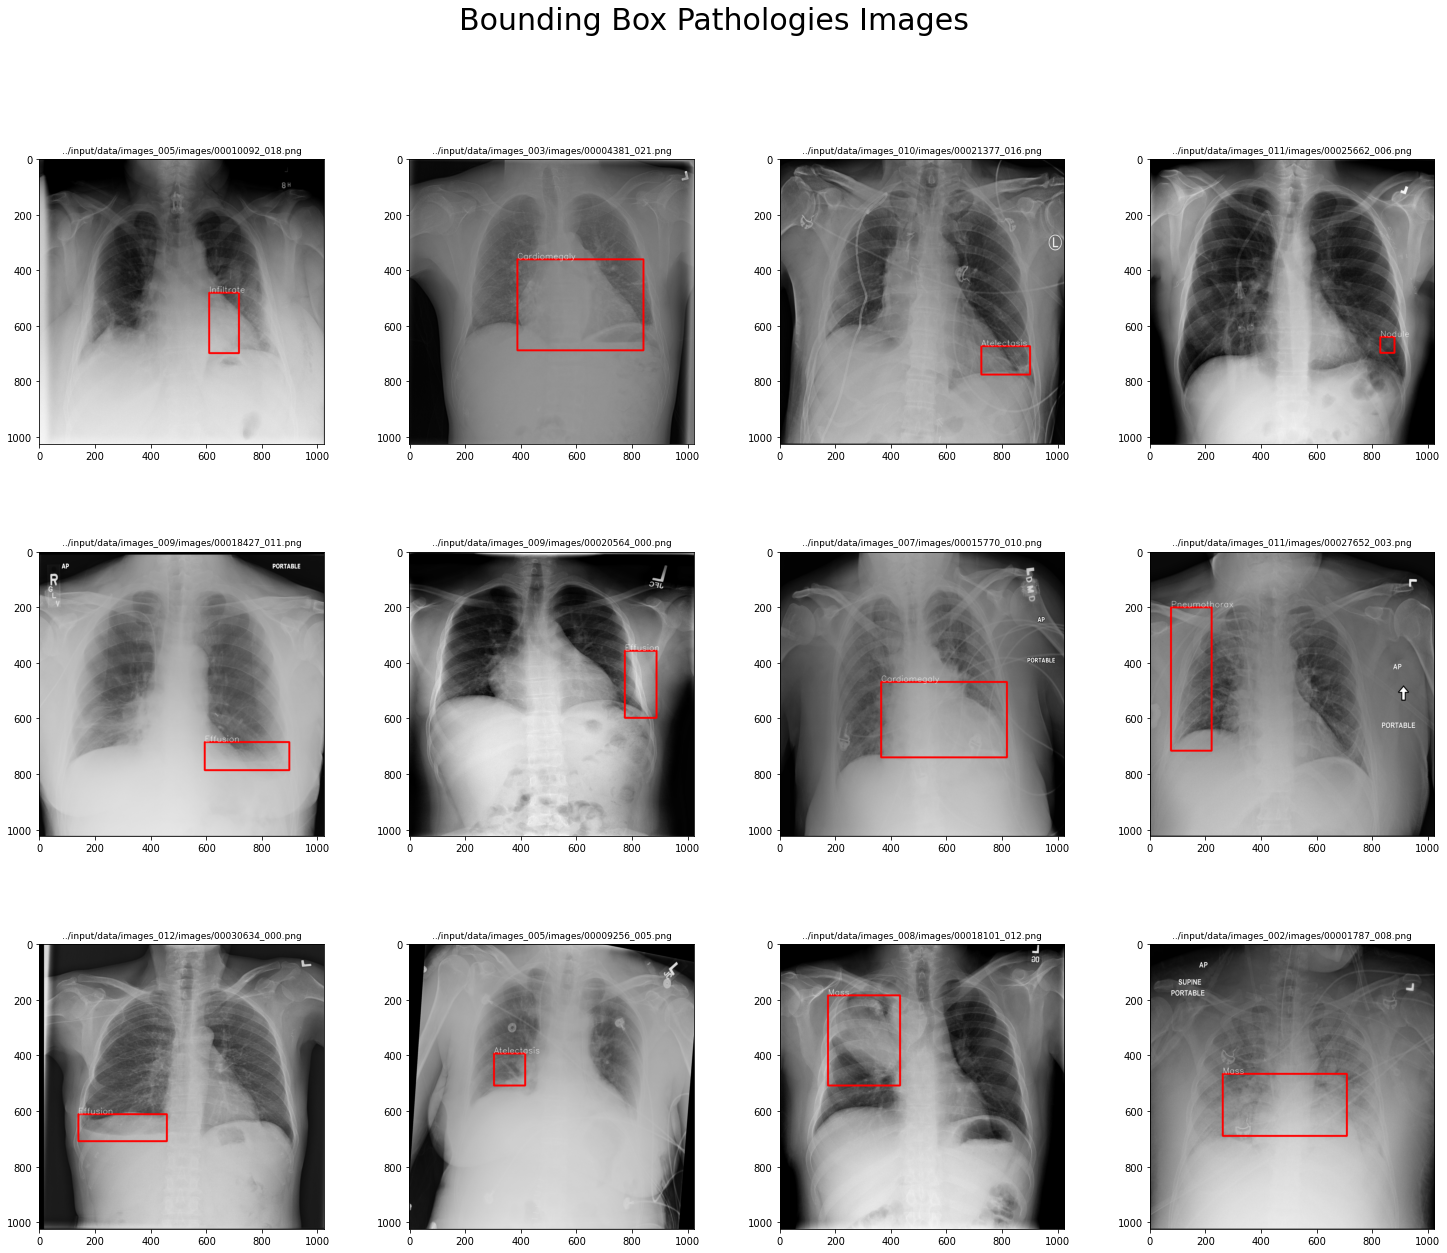

In [55]:
random_bbox_check(df)

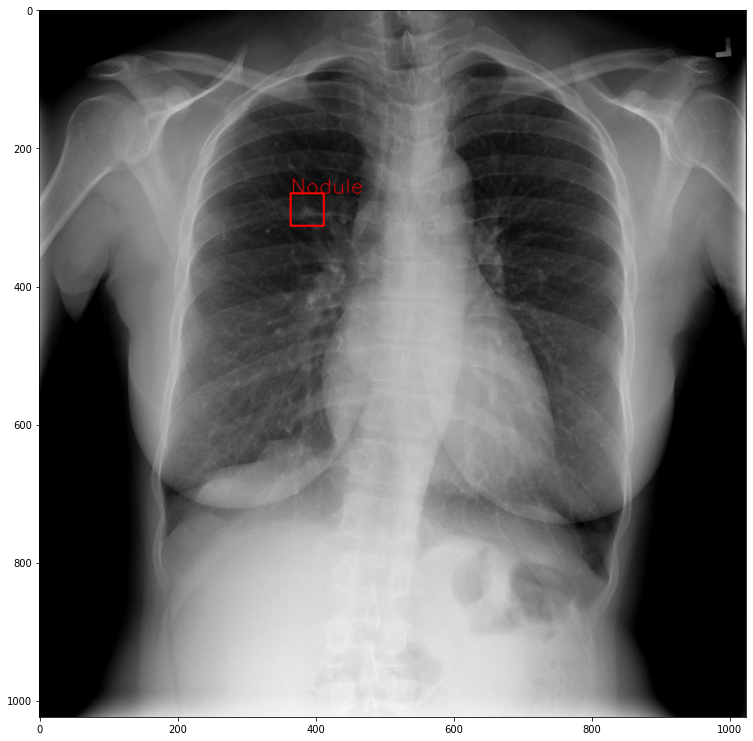

In [58]:
draw_single_img("00026398_000.png")

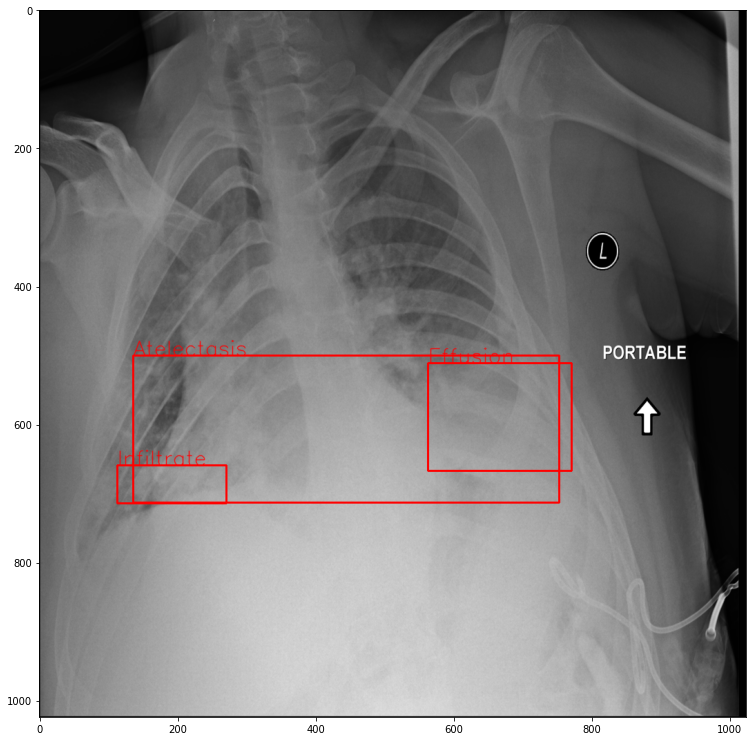

In [59]:
draw_single_img("00021703_001.png")

In [60]:
# image with many annotations
df['file_names'].value_counts()

00010277_000.png    4
00021703_001.png    3
00018253_059.png    3
00010828_039.png    3
00013659_019.png    3
                   ..
00019646_006.png    1
00013922_021.png    1
00005140_001.png    1
00028876_060.png    1
00006096_010.png    1
Name: file_names, Length: 880, dtype: int64

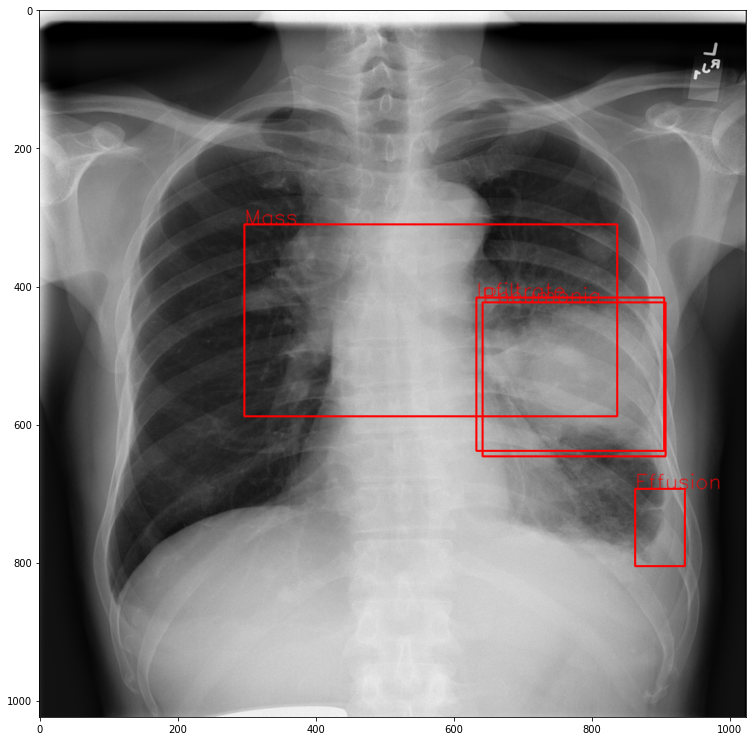

In [61]:
draw_single_img("00010277_000.png")

In [62]:
df[df['file_names'] =="00010277_000.png"]

,file_names,class_names,x,y,w,h,class_id,height,width,xmax,ymax,xmin,ymin,path
404,00010277_000.png,Effusion,0.842778,0.676981,0.071111,0.110000,2,2021,1549,935.822222,805.869045,863.004444,693.229045,../input/data/images_005/images/00010277_000.png
416,00010277_000.png,Infiltrate,0.618333,0.406981,0.265556,0.216667,3,2991,2992,905.102222,638.615712,633.173333,416.749045,../input/data/images_005/images/00010277_000.png
512,00010277_000.png,Pneumonia,0.627222,0.413648,0.258889,0.217778,6,2500,2048,907.377778,646.580156,642.275556,423.575712,../input/data/images_005/images/00010277_000.png
963,00010277_000.png,Mass,0.290556,0.303648,0.527778,0.271111,4,2048,2500,837.973333,588.553490,297.528889,310.935712,../input/data/images_005/images/00010277_000.png


In [63]:
# df['x_mid'] = df.apply(lambda x: (x.x_max+x.x_min)/2, axis =1)
# df['y_mid'] = df.apply(lambda x: (x.y_max+x.y_min)/2, axis =1)
# df['w'] = df.apply(lambda x: (x.x_max-x.x_min), axis =1)
# df['h'] = df.apply(lambda x: (x.y_max-x.y_min), axis =1)

In [64]:
selected_df = df.copy()

In [65]:
# pd.DataFrame(base_details)

TRAIN =[]
for img_id in selected_df['path'].unique():
# for img_id in selected_df[selected_df['path'].isin(img_ids)]['path'].unique():
    curr_df = selected_df[selected_df['path'] ==img_id].reset_index(drop=True)
    base_details = dict(curr_df.loc[0][['path',"file_names", 'width', 'height']])
    information =[]
    for indx in range(curr_df.shape[0]):
        other_details = dict(curr_df.loc[indx][['class_names', 'class_id', "xmin", "ymin","xmax","ymax", "h", "w", "x", "y" ]])
        information.append(other_details)
    
    TRAIN.append([base_details['path'], base_details['file_names'],base_details['width'],base_details['height'],information])

In [66]:
final_data = pd.DataFrame(TRAIN, columns =['image_id', "file_id", "width", "height", "information"])

In [67]:
gkf  = GroupKFold(n_splits = 5)
final_data['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(gkf.split(final_data, groups = final_data.image_id.tolist())):
    final_data.loc[val_idx, 'fold'] = fold
final_data.head()


,image_id,file_id,width,height,information,fold
0,../input/data/images_010/images/00022572_005.png,00022572_005.png,2500,2048,"[{'class_names': 'Effusion', 'class_id': 2, 'x...",4
1,../input/data/images_008/images/00017981_014.png,00017981_014.png,3056,2544,"[{'class_names': 'Infiltrate', 'class_id': 3, ...",0
2,../input/data/images_010/images/00021967_000.png,00021967_000.png,2021,2021,"[{'class_names': 'Effusion', 'class_id': 2, 'x...",4
3,../input/data/images_012/images/00028873_009.png,00028873_009.png,2500,2048,"[{'class_names': 'Cardiomegaly', 'class_id': 1...",1
4,../input/data/images_004/images/00007629_001.png,00007629_001.png,3056,2508,"[{'class_names': 'Pneumonia', 'class_id': 6, '...",3


In [68]:
# get all image ids for both training and validation with the bbox

train_fold_files_ids = []
val_fold_files_ids   = []
val_fold_files_ids += list(final_data[final_data.fold==fold].image_id.unique())
train_fold_files_ids += list(final_data[final_data.fold!=fold].image_id.unique())

In [69]:
len(train_fold_files_ids), len(val_fold_files_ids)

(704, 176)

In [70]:
# shutil.rmtree('/kaggle/working/yolo/labels/train')
# shutil.rmtree('/kaggle/working/yolo/labels/val')
# shutil.rmtree('/kaggle/working/yolo/images/train')
# shutil.rmtree('/kaggle/working/yolo/images/val')

# create thr directorues
os.makedirs('/kaggle/working/yolo/labels/train', exist_ok = True)
os.makedirs('/kaggle/working/yolo/labels/val', exist_ok = True)
os.makedirs('/kaggle/working/yolo/images/train', exist_ok = True)
os.makedirs('/kaggle/working/yolo/images/val', exist_ok = True)

In [71]:
# selected_df

In [72]:
final_classes = list(selected_df['class_names'].unique())
def get_class_id(class_value):    
    return final_classes.index(class_value)

In [73]:
sample_d = final_data[final_data['image_id']== train_fold_files_ids[0]]
sample_d

,image_id,file_id,width,height,information,fold
1,../input/data/images_008/images/00017981_014.png,00017981_014.png,3056,2544,"[{'class_names': 'Infiltrate', 'class_id': 3, ...",0


In [74]:
sample_d['information'].values[0][0]

{'class_names': 'Infiltrate',
 'class_id': 3,
 'xmin': 254.645502645503,
 'ymin': 312.076190476191,
 'xmax': 449.693121693122,
 'ymax': 451.860317460318,
 'h': 0.13650793650793652,
 'w': 0.19047619047619044,
 'x': 0.24867724867724902,
 'y': 0.3047619047619053}

In [75]:
for xq in  sample_d['information'].values[0]:
    print(get_class_id(xq['class_names']), xq['x'], xq['y'], xq['w'] , xq['h'])

1 0.24867724867724902 0.3047619047619053 0.19047619047619044 0.13650793650793652


In [76]:
from tqdm import tqdm_notebook, tqdm, notebook
indexed_final_data = final_data.copy()
indexed_final_data.index = final_data['image_id']

In [77]:
indexed_final_data.head()

,image_id,file_id,width,height,information,fold
image_id,,,,,,
../input/data/images_010/images/00022572_005.png,../input/data/images_010/images/00022572_005.png,00022572_005.png,2500,2048,"[{'class_names': 'Effusion', 'class_id': 2, 'x...",4
../input/data/images_008/images/00017981_014.png,../input/data/images_008/images/00017981_014.png,00017981_014.png,3056,2544,"[{'class_names': 'Infiltrate', 'class_id': 3, ...",0
../input/data/images_010/images/00021967_000.png,../input/data/images_010/images/00021967_000.png,00021967_000.png,2021,2021,"[{'class_names': 'Effusion', 'class_id': 2, 'x...",4
../input/data/images_012/images/00028873_009.png,../input/data/images_012/images/00028873_009.png,00028873_009.png,2500,2048,"[{'class_names': 'Cardiomegaly', 'class_id': 1...",1
../input/data/images_004/images/00007629_001.png,../input/data/images_004/images/00007629_001.png,00007629_001.png,3056,2508,"[{'class_names': 'Pneumonia', 'class_id': 6, '...",3


In [78]:
"00021711_014.png".split(".")[0] 

'00021711_014'

In [79]:
def process_data_for_yolo(df, file_id_lists, data_type='train'):
    """
    Reads details for an image and transfers them to their respective folders when proceesed.
    """
    #iterate through each row
    #for _, row in notebook.tqdm(df.iterrows(), total=len(df)):
    for each_id in notebook.tqdm(file_id_lists, total=len(file_id_lists)):
        #print(each_id, file_id_lists)
        row = df.loc[each_id]
        
        #get img information
        file_id = row['file_id']
        # Convert into the Yolo input format
        yolo_data = []
        for xq in  row['information']:
            curr_bbox_infor = [get_class_id(xq['class_names']), xq['x'], xq['y'], xq['w'] , xq['h']]
            yolo_data.append(curr_bbox_infor)

        # convert to nump array
        yolo_data = np.array(yolo_data)
        #print(yolo_data)
        #copy image to another directory where training will occur
        full_file_path = f"{each_id}"
        shutil.copy(full_file_path, f'/kaggle/working/yolo/images/{data_type}')
        
        #saved format must be class, center (x,y), width, heihgt 
        np.savetxt(os.path.join('/kaggle/working/yolo', 
                                f"labels/{data_type}/{file_id.split('.')[0]}.txt"),
                                yolo_data, 
                                fmt=["%d", "%f", "%f", "%f", "%f"]
                   )

In [80]:
indexed_final_data.loc[train_fold_files_ids[0]]


image_id        ../input/data/images_008/images/00017981_014.png
file_id                                         00017981_014.png
width                                                       3056
height                                                      2544
information    [{'class_names': 'Infiltrate', 'class_id': 3, ...
fold                                                           0
Name: ../input/data/images_008/images/00017981_014.png, dtype: object

In [81]:
# trainin
process_data_for_yolo(indexed_final_data, train_fold_files_ids[:1], 'train')

  0%|          | 0/1 [00:00<?, ?it/s]

In [82]:
with open(os.path.join('/kaggle/working/yolo', f"labels/train/{train_fold_files_ids[:1][0].split('/')[-1].split('.')[0]}.txt")) as filer:
    print(filer.read())

1 0.248677 0.304762 0.190476 0.136508



In [83]:
# process training
process_data_for_yolo(indexed_final_data, train_fold_files_ids, 'train')

# process testing
process_data_for_yolo(indexed_final_data, val_fold_files_ids, 'val')

  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

In [84]:
import yaml

In [85]:
# we use coco format.
CURR_DIR = '/kaggle/working/'
with open(os.path.join( CURR_DIR , 'train.txt'), 'w') as f:
    for path in glob('/kaggle/working/yolo/images/train/*'):
        f.write(path+'\n')

In [86]:
with open(os.path.join( CURR_DIR , 'val.txt'), 'w') as f:
    for path in glob('/kaggle/working/yolo/images/val/*'):
        f.write(path+'\n')

In [87]:
# data infromation

data = dict(
    train =  os.path.join( CURR_DIR , 'train.txt') ,
    val   =  os.path.join( CURR_DIR, 'val.txt' ),
    nc    = len(final_classes),#we hgave x classes
    names = final_classes
    )
data

{'train': '/kaggle/working/train.txt',
 'val': '/kaggle/working/val.txt',
 'nc': 8,
 'names': ['Effusion',
  'Infiltrate',
  'Cardiomegaly',
  'Pneumonia',
  'Mass',
  'Atelectasis',
  'Pneumothorax',
  'Nodule']}

In [88]:
# create yaml file with information of the above two files


with open(os.path.join( CURR_DIR , 'custom.yaml'), 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

In [89]:
f = open(os.path.join( CURR_DIR , 'custom.yaml'), 'r')

print(f.read())

names:
- Effusion
- Infiltrate
- Cardiomegaly
- Pneumonia
- Mass
- Atelectasis
- Pneumothorax
- Nodule
nc: 8
train: /kaggle/working/train.txt
val: /kaggle/working/val.txt



In [90]:
# clone the repo
# https://www.kaggle.com/ultralytics/yolov5
!git clone https://github.com/ultralytics/yolov5
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 15978, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 15978 (delta 89), reused 113 (delta 70), pack-reused 15831
Receiving objects: 100% (15978/15978), 14.60 MiB | 20.83 MiB/s, done.
Resolving deltas: 100% (10962/10962), done.
/kaggle/working/yolov5


In [91]:
os.chdir('/kaggle/working/yolov5')
%pip install -qr requirements.txt # install dependencies

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
google-api-core 1.33.2 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 3.19.4 which is incompatible.
gcsfs 2022.5.0 requires fsspec==2022.5.0, but you have fsspec 2022.8.2 which is incompatible.
dask-cudf 21.10.1 requires dask==2021.09.1, but you have dask 2022.2.0 which is incompatible.
dask-cudf 21.10.1 requires distributed==2021.09.1, but you have distributed 2022.2.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [93]:
!python train.py --img 640 --batch 16 --epochs 5 --data /kaggle/working/custom.yaml --weights yolov5s.pt --exist-ok #--hyp data/hyps/hypEdit.yaml

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: Currently logged in as: stephenkamau. Use `wandb login --relogin` to force relogin
train: weights=yolov5s.pt, cfg=, data=/kaggle/working/custom.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=5, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=True, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-178-ga199480 Python-3.7.12 torch-1.11.0 CUDA:0 (Tesla P100-PCIE-16GB, 

In [ ]:
# THE NEXT IS DETECTRON2 MODEL BY FACEBOOK RESEARCH....................................